In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
import numpy as np
import torch

# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist 

#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

import matplotlib.pyplot as plt

In [3]:
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5

In [4]:
#定义预处理函数，这些预处理依次放在Compose函数中。
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('G:\\work\\coding\\python\\pytorch\\data\\MNIST\\raw', train=True, transform=transform, download=False)
test_dataset = mnist.MNIST('G:\\work\\coding\\python\\pytorch\\data\\MNIST\\raw', train=False, transform=transform)

#dataloader是一个可迭代对象，可以使用迭代器一样使用。
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

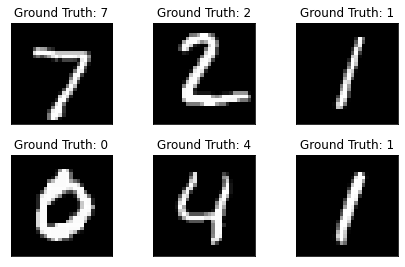

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
 
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [6]:
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        
 
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [8]:
#检测是否有可用的GPU，有则使用，否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
device

device(type='cuda', index=0)

In [10]:
#实例化网络
model = Net(28 * 28, 300, 100, 10)
model.to(device)
 
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [11]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []
 
 
for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    #动态修改参数学习率
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.1
    for img, label in train_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), 
                     eval_loss / len(test_loader), eval_acc / len(test_loader)))

epoch: 0, Train Loss: 0.9856, Train Acc: 0.7976, Test Loss: 0.5321, Test Acc: 0.9022
epoch: 1, Train Loss: 0.4689, Train Acc: 0.9000, Test Loss: 0.3457, Test Acc: 0.9259
epoch: 2, Train Loss: 0.3419, Train Acc: 0.9202, Test Loss: 0.2660, Test Acc: 0.9378
epoch: 3, Train Loss: 0.2813, Train Acc: 0.9323, Test Loss: 0.2255, Test Acc: 0.9445
epoch: 4, Train Loss: 0.2396, Train Acc: 0.9409, Test Loss: 0.1957, Test Acc: 0.9501
epoch: 5, Train Loss: 0.2207, Train Acc: 0.9455, Test Loss: 0.1914, Test Acc: 0.9501
epoch: 6, Train Loss: 0.2176, Train Acc: 0.9465, Test Loss: 0.1906, Test Acc: 0.9507
epoch: 7, Train Loss: 0.2135, Train Acc: 0.9472, Test Loss: 0.1892, Test Acc: 0.9515
epoch: 8, Train Loss: 0.2131, Train Acc: 0.9473, Test Loss: 0.1871, Test Acc: 0.9534
epoch: 9, Train Loss: 0.2089, Train Acc: 0.9489, Test Loss: 0.1834, Test Acc: 0.9532
epoch: 10, Train Loss: 0.2066, Train Acc: 0.9495, Test Loss: 0.1860, Test Acc: 0.9536
epoch: 11, Train Loss: 0.2059, Train Acc: 0.9492, Test Loss: 0.1

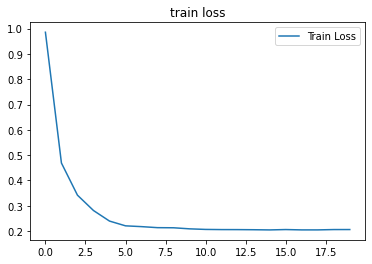

In [12]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'], loc='upper right')

# 优化器比较

In [13]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
 
 
# 超参数
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12

In [14]:
# 生成训练数据
# torch.unsqueeze() 的作用是将一维变二维，torch只能处理二维的数据
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)  
# 0.1 * torch.normal(x.size())增加噪点
y = x.pow(2) + 0.1 * torch.normal(torch.zeros(*x.size()))
 
torch_dataset = Data.TensorDataset(x,y)
#得到一个代批量的生成器
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
class Net(torch.nn.Module):
    # 初始化
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)
        self.predict = torch.nn.Linear(20, 1)
 
    # 前向传递
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

In [16]:
net_SGD = Net()
net_Momentum = Net()
net_RMSProp = Net()
net_Adam = Net()
 
nets = [net_SGD, net_Momentum, net_RMSProp, net_Adam]
 
opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
opt_RMSProp = torch.optim.RMSprop(net_RMSProp.parameters(), lr=LR, alpha=0.9)
opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSProp, opt_Adam]

In [17]:
loss_func = torch.nn.MSELoss() 
loss_his = [[], [], [], []]  # 记录损失 
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, opt,l_his in zip(nets, optimizers, loss_his):
            output = net(batch_x)  # get output for every net
            loss = loss_func(output, batch_y)  # compute loss for every net
            opt.zero_grad()  # clear gradients for next train
            loss.backward()  # backpropagation, compute gradients
            opt.step()  # apply gradients
            l_his.append(loss.data.numpy())  # loss recoder
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']

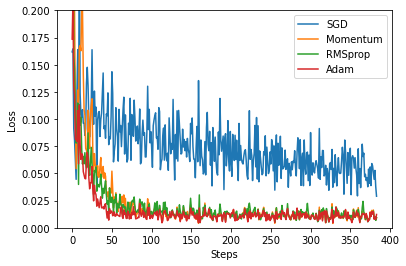

In [18]:
for i, l_his in enumerate(loss_his):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.2))
plt.show()